<a href="https://colab.research.google.com/github/haozhez4/CS441-Final_Project/blob/main/cs441_final_project_logistic_regression_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# =====================================
# 1. Import Libraries
# =====================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# =====================================
# 2. Load Data
# =====================================
df = pd.read_csv('/content/hs300_clean_data.csv')

df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(['code', 'time']).reset_index(drop=True)

print("Data loaded:", df.shape)
df.head()


Data loaded: (211200, 20)


,time,code,open,close,high,low,volume,money,avg_price,change_pct,net_amount_main,net_pct_main,net_amount_xl,net_pct_xl,net_amount_l,net_pct_l,net_amount_m,net_pct_m,net_amount_s,net_pct_s
0,2023-01-03,000001.XSHE,11.18,11.66,11.73,11.05,259167169.0,2.971547e+09,11.465754,NaN,4.740562e+08,15.953178,3.868693e+07,1.301912,2.783494e+07,0.936716,1.324973e+08,4.458867,1.489622e+08,5.012953
1,2023-01-04,000001.XSHE,11.61,12.12,12.21,11.54,258642084.0,3.110729e+09,12.027159,3.945111,9.979168e+08,32.079833,1.898494e+08,6.103051,-2.370479e+07,-0.762033,-3.114577e+08,-10.012368,7.277440e+07,2.339464
2,2023-01-05,000001.XSHE,12.19,12.26,12.48,12.17,196717576.0,2.417272e+09,12.288034,1.155116,5.469255e+08,22.625729,9.238716e+07,3.821959,6.690563e+07,2.767815,-1.832146e+08,-7.579393,1.392120e+08,5.759054
3,2023-01-06,000001.XSHE,12.28,12.38,12.46,12.26,141239608.0,1.747915e+09,12.375531,0.978793,2.063995e+08,11.808324,2.322596e+07,1.328780,6.074761e+07,3.475432,1.893692e+07,1.083400,-4.677750e+07,-2.676188
4,2023-01-09,000001.XSHE,12.49,12.53,12.60,12.29,124929140.0,1.561368e+09,12.498033,1.211632,2.039346e+08,13.061273,-3.027859e+07,-1.939234,3.008996e+07,1.927153,2.811659e+07,1.800766,8.387969e+07,5.372190


In [3]:
# =====================================
# 3. Generate next day return & labels (USE ALL DATA)
# =====================================

df['next_close'] = df.groupby('code')['close'].shift(-1)
df['ret'] = (df['next_close'] - df['close']) / df['close']

# keep ALL rows except the last day of each code (next_close is NaN)
df = df.dropna(subset=['ret'])

# 3-class labels
# Down: 0, Flat: 1, Up: 2
df['label'] = np.where(df['ret'] >= 0.002, 2,
                np.where(df['ret'] <= -0.002, 0, 1))

print("Data after labeling (no drop):", df.shape)


# =====================================
# 4. Create 10-day lag window features
# =====================================

for i in range(1, 11):
    df[f'close_lag{i}'] = df.groupby('code')['close'].shift(i)

df = df.dropna(subset=[f'close_lag10'])
print("Data after adding lag features:", df.shape)


# =====================================
# 5. Time-based split (70/15/15)
# =====================================

X = df[[f'close_lag{i}' for i in range(1, 11)]]
y = df['label']
times = df['time']

unique_dates = sorted(times.unique())
n = len(unique_dates)

train_end = unique_dates[int(n * 0.70)]
val_end   = unique_dates[int(n * 0.85)]

train_idx = times <= train_end
val_idx   = (times > train_end) & (times <= val_end)
test_idx  = times > val_end

print("Train size:", train_idx.sum())
print("Val size:", val_idx.sum())
print("Test size:", test_idx.sum())


# =====================================
# 6. Standardize + Train Logistic Regression (multiclass)
# =====================================

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X[train_idx])
X_val   = scaler.transform(X[val_idx])
X_test  = scaler.transform(X[test_idx])

y_train = y[train_idx]
y_val   = y[val_idx]
y_test  = y[test_idx]

clf = LogisticRegression(max_iter=2000, multi_class='multinomial')
clf.fit(X_train, y_train)
print("Training completed!")


# =====================================
# 7. Predict test set + Top-5 strategy (use P(Up))
# =====================================

df_test = df[test_idx].copy()

# class order is clf.classes_ (should be [0,1,2])
probs = clf.predict_proba(X_test)
up_class_index = list(clf.classes_).index(2)

df_test['pred_prob_up'] = probs[:, up_class_index]

results = []
for date, group in df_test.groupby('time'):
    top5 = group.nlargest(5, 'pred_prob_up')
    avg_ret = top5['ret'].mean()
    results.append({'date': date, 'daily_return': avg_ret})

res_df = pd.DataFrame(results).sort_values('date')
res_df['cum_return'] = (1 + res_df['daily_return']).cumprod()

res_df.tail()


Data after labeling (no drop): (209641, 23)
Data after adding lag features: (206641, 33)
Train size: 144565
Val size: 31176
Test size: 30900


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training completed!


,date,daily_return,cum_return
98,2025-11-21,-0.012083,1.125918
99,2025-11-24,0.026008,1.155202
100,2025-11-25,0.022858,1.181608
101,2025-11-26,-0.002151,1.179066
102,2025-11-27,0.008412,1.188984


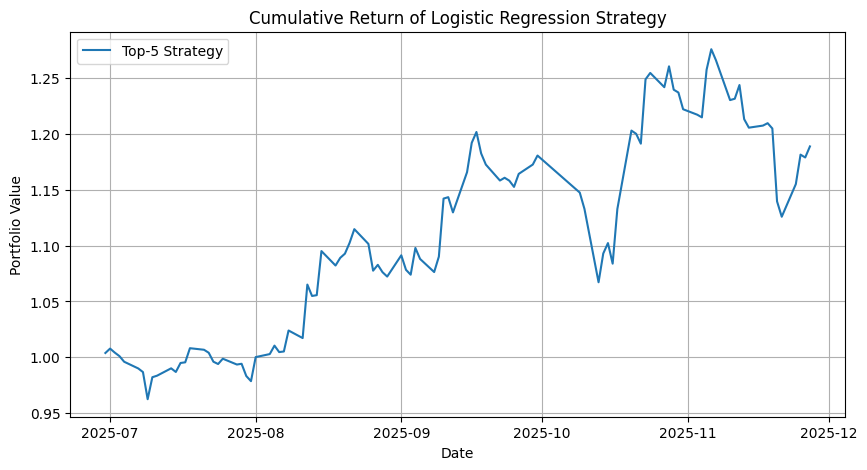

In [4]:
# =====================================
# 8. Plot cumulative return
# =====================================

plt.figure(figsize=(10,5))
plt.plot(res_df['date'], res_df['cum_return'], label='Top-5 Strategy')
plt.title("Cumulative Return of Logistic Regression Strategy")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.show()


In [5]:
# Recompute binary labels and weights using 0.2% threshold
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

df['label'] = (df['ret'] > 0).astype(int)
df['weight'] = np.where(df['ret'].abs() >= 0.002, 1.0, 0.3)

# Recreate feature matrix and indices
X = df[[f'close_lag{i}' for i in range(1, 11)]]
y = df['label']
weights = df['weight']
times = df['time']

unique_dates = sorted(times.unique())
n = len(unique_dates)
train_end = unique_dates[int(n * 0.70)]
val_end = unique_dates[int(n * 0.85)]

train_idx = times <= train_end
val_idx = (times > train_end) & (times <= val_end)
test_idx = times > val_end

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X[train_idx])
X_val = scaler.transform(X[val_idx])
X_test = scaler.transform(X[test_idx])

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]
w_train = weights[train_idx]

# Train binary logistic regression with sample weights
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train, sample_weight=w_train)

# Predict probability of up class (1)
df_test = df[test_idx].copy()
probs = clf.predict_proba(X_test)
up_idx = list(clf.classes_).index(1)
df_test['pred_prob_up'] = probs[:, up_idx]

# Top-5 strategy using predicted probabilities
results = []
for date, group in df_test.groupby('time'):
    top5 = group.nlargest(5, 'pred_prob_up')
    avg_ret = top5['ret'].mean()
    results.append({'date': date, 'daily_return': avg_ret})

res_df = pd.DataFrame(results).sort_values('date')
res_df['cum_return'] = (1 + res_df['daily_return']).cumprod()
res_df.tail()

,date,daily_return,cum_return
98,2025-11-21,-0.006355,1.164629
99,2025-11-24,0.026008,1.194919
100,2025-11-25,0.027170,1.227385
101,2025-11-26,-0.001141,1.225984
102,2025-11-27,0.008412,1.236297


In [6]:
print('Train size:', train_idx.sum())
print('Val size:', val_idx.sum())
print('Test size:', test_idx.sum())


Train size: 144565
Val size: 31176
Test size: 30900


In [7]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Accuracy: 0.5218446601941747
              precision    recall  f1-score   support

           0       0.52      1.00      0.69     16103
           1       0.63      0.00      0.01     14797

    accuracy                           0.52     30900
   macro avg       0.58      0.50      0.35     30900
weighted avg       0.57      0.52      0.36     30900



In [8]:
# Logistic Regression baseline with 50 lagged features

# 1. Compute next-day return and binary labels
import numpy as np
import pandas as pd

# Copy original dataframe to avoid modifying df used elsewhere
# Assume df has columns: time, code, open, high, low, close, volume, etc.
df_lr = df.copy()

# Compute next day's close and return
df_lr['next_close'] = df_lr.groupby('code')['close'].shift(-1)
df_lr['ret'] = (df_lr['next_close'] - df_lr['close']) / df_lr['close']
# Drop rows where return is NaN (last day of each stock)
df_lr = df_lr.dropna(subset=['ret'])

# Binary label: 1 if next-day return positive, 0 otherwise
df_lr['label'] = (df_lr['ret'] > 0).astype(int)

# 2. Create 10-day lag features for close, volume, ret, high, low
cols = ['close', 'volume', 'ret', 'high', 'low']
for col in cols:
    for i in range(1, 11):
        df_lr[f'{col}_lag{i}'] = df_lr.groupby('code')[col].shift(i)

# List of all lagged feature column names
lag_cols = [f'{col}_lag{i}' for col in cols for i in range(1, 11)]

# Drop rows with any missing values in lagged features
df_lr = df_lr.dropna(subset=lag_cols)

# 3. Build feature matrix X and labels y
X = df_lr[lag_cols]
y = df_lr['label']
times = df_lr['time']

# 4. Time-based split (70/15/15)
unique_dates = sorted(times.unique())
n = len(unique_dates)
train_end = unique_dates[int(n * 0.70)]
val_end = unique_dates[int(n * 0.85)]

train_idx = times <= train_end
val_idx = (times > train_end) & (times <= val_end)
test_idx = times > val_end

# 5. Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X[train_idx])
X_val = scaler.transform(X[val_idx])
X_test = scaler.transform(X[test_idx])

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]

# 6. Train Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=2000)
clf_lr.fit(X_train, y_train)

# 7. Evaluate classification metrics on test set
from sklearn.metrics import accuracy_score, classification_report
y_pred = clf_lr.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.5236928104575164
              precision    recall  f1-score   support

           0       0.52      0.96      0.68     15984
           1       0.52      0.04      0.08     14616

    accuracy                           0.52     30600
   macro avg       0.52      0.50      0.38     30600
weighted avg       0.52      0.52      0.39     30600



In [9]:
np.random.seed(42)
random_probs = np.random.rand(len(df_test))
df_test['rand_prob'] = random_probs

results_rand = []
for date, group in df_test.groupby('time'):
    top5 = group.nlargest(5, 'rand_prob')
    avg_ret = top5['ret'].mean()
    results_rand.append({'date': date, 'daily_return': avg_ret})

rand_df = pd.DataFrame(results_rand).sort_values('date')
rand_df['cum_return'] = (1 + rand_df['daily_return']).cumprod()


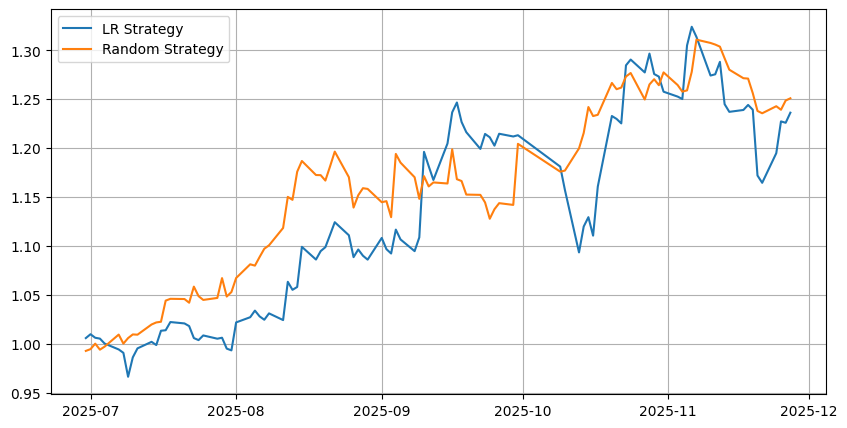

In [10]:
plt.figure(figsize=(10,5))
plt.plot(res_df['date'], res_df['cum_return'], label='LR Strategy')
plt.plot(rand_df['date'], rand_df['cum_return'], label='Random Strategy')
plt.legend()
plt.grid(True)
plt.show()


Sizes after adding features (df2):
Train: 144266 Val: 31175 Test: 30900
Test Accuracy with extra features: 0.5213592233009708
              precision    recall  f1-score   support

           0       0.52      1.00      0.68     16103
           1       0.52      0.01      0.01     14797

    accuracy                           0.52     30900
   macro avg       0.52      0.50      0.35     30900
weighted avg       0.52      0.52      0.36     30900



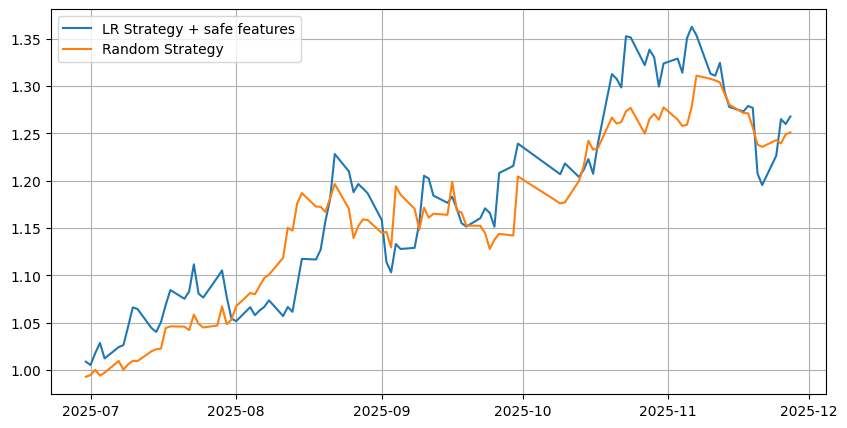

In [11]:
# =========================
# Add safe features (FIXED)
# =========================

# 1) Create lag features
df['volume_lag1'] = df.groupby('code')['volume'].shift(1)
df['ret_lag1'] = df.groupby('code')['ret'].shift(1)

# 2) Drop NaNs introduced by lagging (IMPORTANT)
df2 = df.dropna(subset=['close_lag10', 'volume_lag1', 'ret_lag1']).copy()

# 3) Build X/y
X = df2[[f'close_lag{i}' for i in range(1, 11)] + ['volume_lag1', 'ret_lag1']]
y = df2['label']
times = df2['time']

# 4) Time split
unique_dates = sorted(times.unique())
n = len(unique_dates)
train_end = unique_dates[int(n * 0.70)]
val_end   = unique_dates[int(n * 0.85)]

train_idx = times <= train_end
val_idx   = (times > train_end) & (times <= val_end)
test_idx  = times > val_end

print("Sizes after adding features (df2):")
print("Train:", train_idx.sum(), "Val:", val_idx.sum(), "Test:", test_idx.sum())

# 5) Weights (keep the same 0.2% logic)
weights = np.where(df2['ret'].abs() >= 0.002, 1.0, 0.3)

# 6) Standardize + Train
scaler = StandardScaler()
X_train = scaler.fit_transform(X[train_idx])
X_val   = scaler.transform(X[val_idx])
X_test  = scaler.transform(X[test_idx])

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y[train_idx], sample_weight=weights[train_idx])

# 7) Metrics
from sklearn.metrics import accuracy_score, classification_report
y_pred = clf.predict(X_test)
print("Test Accuracy with extra features:", accuracy_score(y[test_idx], y_pred))
print(classification_report(y[test_idx], y_pred))

# 8) Strategy
df_test = df2[test_idx].copy()
probs = clf.predict_proba(X_test)
up_idx = list(clf.classes_).index(1)
df_test['pred_prob_up'] = probs[:, up_idx]

results = []
for date, group in df_test.groupby('time'):
    top5 = group.nlargest(5, 'pred_prob_up')
    results.append({'date': date, 'daily_return': top5['ret'].mean()})

res_df = pd.DataFrame(results).sort_values('date')
res_df['cum_return'] = (1 + res_df['daily_return']).cumprod()

# 9) Random baseline
np.random.seed(42)
df_test['rand_prob'] = np.random.rand(len(df_test))

results_rand = []
for date, group in df_test.groupby('time'):
    top5r = group.nlargest(5, 'rand_prob')
    results_rand.append({'date': date, 'daily_return': top5r['ret'].mean()})

rand_df = pd.DataFrame(results_rand).sort_values('date')
rand_df['cum_return'] = (1 + rand_df['daily_return']).cumprod()

# 10) Plot
plt.figure(figsize=(10,5))
plt.plot(res_df['date'], res_df['cum_return'], label='LR Strategy + safe features')
plt.plot(rand_df['date'], rand_df['cum_return'], label='Random Strategy')
plt.legend()
plt.grid(True)
plt.show()
